In [1]:
##############マウント#####################
from google.colab import drive
import os
import glob

drive.mount('/content/drive/') #マウント
#os.chdir('/drive') #MyDriveにディレクトリ移動
%cd /content/drive/MyDrive
root_path = os.getcwd()
print("root_path : " + str(root_path)) #現在のディレクトリ確認

for name in glob.glob("*"): #ディレクトリ直下のフォルダとファイルを全参照
  print("directries : " + str(name))

print(type(glob.glob("*")))

Mounted at /content/drive/
/content/drive/MyDrive
root_path : /content/drive/MyDrive
directries : j_py02.json
directries : Colab
directries : colabo_pro
directries : datasets
directries : sample_100.jpg
directries : test2.jpg
directries : example1
<class 'list'>


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers!pip install tensorflow_addons
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 13.4 MB/s 


In [2]:
#データの用意
num_classes = 2
input_shape = (128, 128, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
#x_train = np.load('/content/drive/MyDrive/datasets/ndarray/X_train_5_normal.npy')
#x_test = np.load('/content/drive/MyDrive/datasets/ndarray/X_test_5_normal.npy')
#y_train = np.load('/content/drive/MyDrive/datasets/ndarray/y_train_5_normal.npy')
#y_test = np.load('/content/drive/MyDrive/datasets/ndarray/y_test_5_normal.npy')

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#ここから書き足し
print(type(x_train))
print(type(x_test))

169001437/169001437 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [14]:
#パラメータ
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [15]:
#データ拡張
data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.02),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [16]:
#MLPの定義
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x


In [17]:
#パッチ作成レイヤー
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


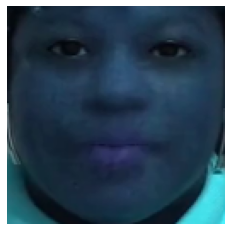

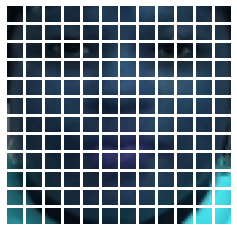

In [18]:
#画像分割したものを表示
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4)) #プロットする図そのものを定義
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1])) #分割処理
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [19]:
#線形化と位置埋め込み
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [20]:
#ViTエンコーダー
def create_vit_classifier():
    inputs = keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [21]:
#実行
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss = 'binary_crossentropy', #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'
            #keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            #keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test) #, top_5_accuracy
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

#print(model.summary())
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
11/11 [==============================] - 18s 696ms/step - loss: 3.3073 - accuracy: 0.4904 - val_loss: 2.1276 - val_accuracy: 0.5586
Epoch 2/100
11/11 [==============================] - 5s 489ms/step - loss: 2.8788 - accuracy: 0.5012 - val_loss: 2.1276 - val_accuracy: 0.5586
Epoch 3/100
11/11 [==============================] - 5s 496ms/step - loss: 2.8788 - accuracy: 0.5061 - val_loss: 2.1276 - val_accuracy: 0.5586
Epoch 4/100
11/11 [==============================] - 6s 498ms/step - loss: 2.8788 - accuracy: 0.4977 - val_loss: 2.1276 - val_accuracy: 0.5586
Epoch 5/100
11/11 [==============================] - 5s 494ms/step - loss: 2.8788 - accuracy: 0.4985 - val_loss: 2.1276 - val_accuracy: 0.5586
Epoch 6/100
11/11 [==============================] - 5s 496ms/step - loss: 2.8788 - accuracy: 0.4992 - val_loss: 2.1276 - val_accuracy: 0.5586
Epoch 7/100
11/11 [==============================] - 5s 489ms/step - loss: 2.8788 - accuracy: 0.4985 - val_loss: 2.1276 - val_accuracy: 0.558